In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append('../../../marine/pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [3]:
import elitism

In [4]:
from scipy.spatial import ConvexHull

In [5]:
import networkx as nx

In [6]:
x0,y0 = 25, 80

# FEM Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

# Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 10000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0    

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    try:
        tmp, const = fast_stopt(args, x)
        if const>(60+binatodeci(individual[-4:]))/100:
            return PENALTY_VALUE, 
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [28]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [29]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).reshape(x0,y0)
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    

gen	nevals	min    	avg        
0  	300   	1519.41	1.30202e+06
1  	248   	1497.31	4709.67    
2  	252   	1391.11	2367.04    
3  	242   	1342.01	2836.64    
4  	248   	1321.37	1656.15    
5  	249   	1250.22	1536.82    
6  	244   	1244.01	1469.6     
7  	249   	1179.31	1407.72    
8  	254   	1135.04	1354.05    
9  	244   	1133.18	1292.18    
10 	257   	1072.74	1234.25    
11 	252   	1033.18	1194.59    
12 	237   	996.745	1153.91    
13 	239   	971.986	1119.52    
14 	259   	929.71 	1083.35    
15 	261   	901.267	1047.33    
16 	238   	871.115	1014.66    
17 	248   	871.115	979.001    
18 	241   	842.095	948.05     
19 	250   	810.035	922.704    
20 	240   	790.401	894.579    
21 	243   	788.055	866.384    
22 	247   	769.568	843.852    
23 	248   	769.554	825.501    
24 	237   	727.514	807.02     
25 	253   	712.223	796.165    
26 	240   	712.223	784.25     
27 	251   	697.962	770.029    
28 	237   	696.188	752.048    
29 	246   	678.486	736.415    
30 	252   	662.94 	719.93     
31 	250 

264	253   	368.881	371.009    
265	253   	368.24 	370.516    
266	248   	368.093	370.186    
267	244   	366.643	369.563    
268	232   	366.643	369.032    
269	246   	365.78 	368.569    
270	250   	365.743	368.117    
271	257   	364.874	367.614    
272	241   	364.356	366.937    
273	237   	363.4  	366.407    
274	232   	363.223	365.975    
275	246   	363.195	365.471    
276	250   	362.778	365.307    
277	245   	361.759	364.409    
278	240   	361.759	363.704    
279	233   	360.366	363.17     
280	253   	360.366	362.705    
281	261   	359.719	362.123    
282	240   	358.786	361.563    
283	259   	358.021	361.021    
284	245   	357.596	360.457    
285	254   	357.373	359.941    
286	243   	357.088	359.174    
287	253   	356.653	358.461    
288	241   	356.295	357.905    
289	241   	355.297	357.364    
290	247   	355.165	357.01     
291	243   	354.828	356.623    
292	243   	354.466	356.302    
293	239   	353.757	355.832    
294	240   	353.41 	355.452    
295	243   	352.642	354.994    
296	244 

529	251   	288.218	362.226    
530	245   	288.185	364.53     
531	241   	287.966	355.035    
532	248   	287.882	397.622    
533	255   	287.726	385.709    
534	238   	287.726	380.887    
535	249   	287.586	361.827    
536	237   	287.574	387.827    
537	249   	287.487	359.299    
538	240   	287.487	387.7      
539	245   	287.283	356.774    
540	243   	287.283	378.021    
541	243   	287.283	389.842    
542	252   	287.283	366.031    
543	245   	287.187	354.106    
544	243   	287.187	380.171    
545	251   	287.164	370.62     
546	258   	287.051	380.084    
547	242   	287.02 	384.797    
548	237   	287.02 	384.774    
549	257   	286.846	372.863    
550	241   	286.846	389.451    
551	232   	286.846	368.014    
552	243   	286.74 	379.905    
553	248   	286.74 	348.939    
554	244   	286.74 	360.743    
555	241   	286.693	372.594    
556	250   	286.693	372.554    
557	255   	286.599	398.696    
558	251   	286.599	384.423    
559	255   	286.431	396.571    
560	250   	286.296	381.967    
561	246 

794	252   	272.315	360.129    
795	251   	272.315	352.771    
796	244   	272.315	343.03     
797	246   	272.315	372.157    
798	255   	272.168	369.644    
799	249   	272.168	355.044    
800	241   	272.156	376.808    
801	246   	272.156	369.495    
802	241   	272.156	345.235    
803	255   	272.156	381.61     
804	244   	272.156	367.018    
805	254   	272.098	374.252    
806	248   	272.075	369.383    
807	253   	272.055	354.793    
808	248   	272.055	379.022    
809	251   	271.975	342.58     
810	228   	271.975	374.102    
811	239   	271.921	357.089    
812	248   	271.921	342.524    
813	240   	271.83 	330.382    
814	249   	271.83 	374.037    
815	245   	271.83 	354.642    
816	242   	271.83 	383.743    
817	242   	271.83 	371.589    
818	254   	271.799	369.153    
819	254   	271.762	359.419    
820	250   	271.762	383.802    
821	250   	271.723	383.672    
822	248   	271.601	361.761    
823	243   	271.601	376.296    
824	249   	271.594	373.919    
825	235   	271.594	386.014    
826	245 

1057	251   	266.506	376.815    
1058	232   	266.506	354.774    
1059	242   	266.441	367.028    
1060	246   	266.405	354.82     
1061	251   	266.405	364.559    
1062	238   	266.405	381.623    
1063	252   	266.361	357.11     
1064	241   	266.306	361.955    
1065	244   	266.306	347.3      
1066	238   	266.306	330.15     
1067	251   	266.306	344.739    
1068	248   	266.261	359.437    
1069	247   	266.261	376.517    
1070	250   	266.208	359.376    
1071	262   	266.208	349.564    
1072	239   	266.208	391.157    
1073	246   	266.207	374.02     
1074	255   	266.117	381.314    
1075	244   	266.117	373.962    
1076	245   	266.117	334.831    
1077	243   	266.108	376.374    
1078	239   	266.102	364.148    
1079	252   	266.065	356.813    
1080	251   	266.065	386.142    
1081	242   	265.958	376.321    
1082	244   	265.958	349.447    
1083	246   	265.958	376.353    
1084	249   	265.958	383.714    
1085	244   	265.956	356.695    
1086	242   	265.936	366.456    
1087	253   	265.91 	395.821    
1088	248

1314	257   	262.198	336.088    
1315	254   	262.156	338.641    
1316	254   	262.142	331.194    
1317	249   	262.142	316.409    
1318	245   	262.142	323.767    
1319	247   	262.117	326.221    
1320	236   	262.117	316.37     
1321	243   	262.117	333.601    
1322	250   	262.117	306.512    
1323	249   	262.081	340.992    
1324	245   	262.081	313.961    
1325	242   	262.081	326.273    
1326	253   	262.081	323.815    
1327	226   	262.081	340.904    
1328	241   	262.081	316.27     
1329	242   	262.072	316.28     
1330	245   	262.072	331.019    
1331	244   	262.072	316.278    
1332	243   	262.072	303.953    
1333	243   	262.072	308.873    
1334	242   	262.069	313.802    
1335	241   	262.008	299.129    
1336	231   	261.991	308.862    
1337	240   	261.991	316.226    
1338	244   	261.991	328.558    
1339	235   	261.991	321.147    
1340	246   	261.991	333.581    
1341	258   	261.925	330.98     
1342	246   	261.919	328.512    
1343	246   	261.919	336.197    
1344	241   	261.849	328.503    
1345	251

1571	248   	259.515	368.341    
1572	251   	259.48 	351.006    
1573	247   	259.48 	385.516    
1574	247   	259.48 	368.231    
1575	231   	259.48 	353.418    
1576	256   	259.468	373.151    
1577	261   	259.467	371.008    
1578	246   	259.467	383.342    
1579	245   	259.467	375.92     
1580	255   	259.467	415.085    
1581	247   	259.383	365.821    
1582	239   	259.383	387.924    
1583	245   	259.375	373.123    
1584	237   	259.371	368.147    
1585	238   	259.347	378.04     
1586	249   	259.347	375.922    
1587	235   	259.347	363.237    
1588	244   	259.33 	370.604    
1589	241   	259.307	353.288    
1590	247   	259.307	365.621    
1591	241   	259.307	363.145    
1592	239   	259.307	345.861    
1593	237   	259.291	345.851    
1594	244   	259.291	370.531    
1595	238   	259.287	340.884    
1596	241   	259.27 	343.334    
1597	241   	259.267	326.209    
1598	259   	259.267	318.624    
1599	245   	259.267	345.763    
1600	238   	259.258	330.966    
1601	244   	259.258	340.845    
1602	249

1828	247   	257.647	354.325    
1829	242   	257.646	366.753    
1830	239   	257.646	376.58     
1831	246   	257.646	396.383    
1832	249   	257.646	376.593    
1833	250   	257.619	364.192    
1834	244   	257.619	376.585    
1835	230   	257.619	364.49     
1836	247   	257.612	371.571    
1837	246   	257.612	369.151    
1838	249   	257.608	349.277    
1839	241   	257.608	346.806    
1840	240   	257.596	364.109    
1841	250   	257.596	361.61     
1842	243   	257.588	344.292    
1843	242   	257.57 	336.89     
1844	247   	257.57 	329.441    
1845	249   	257.557	319.523    
1846	248   	257.547	336.843    
1847	247   	257.547	359.125    
1848	241   	257.547	344.268    
1849	243   	257.539	349.192    
1850	238   	257.539	344.433    
1851	254   	257.539	314.6      
1852	242   	257.539	339.334    
1853	231   	257.539	309.57     
1854	245   	257.539	329.407    
1855	243   	257.536	321.959    
1856	250   	257.536	329.352    
1857	247   	257.536	346.678    
1858	254   	257.516	317.013    
1859	247

2085	243   	256.301	288.606    
2086	241   	256.3  	303.486    
2087	256   	256.3  	315.862    
2088	239   	256.247	340.666    
2089	237   	256.232	313.387    
2090	256   	256.232	350.589    
2091	254   	256.232	360.482    
2092	240   	256.227	345.593    
2093	246   	256.178	350.55     
2094	251   	256.178	363.24     
2095	238   	256.178	365.389    
2096	240   	256.178	348.052    
2097	256   	256.178	348.041    
2098	248   	256.178	338.086    
2099	245   	256.178	323.286    
2100	240   	256.165	320.712    
2101	250   	256.165	328.132    
2102	241   	256.165	290.958    
2103	239   	256.165	278.527    
2104	238   	256.112	276.059    
2105	242   	256.112	280.999    
2106	235   	256.112	278.546    
2107	249   	256.112	293.403    
2108	252   	256.112	278.513    
2109	238   	256.078	293.425    
2110	244   	256.078	310.775    
2111	248   	256.078	333.088    
2112	255   	256.078	338.039    
2113	247   	256.078	330.707    
2114	249   	256.074	372.738    
2115	242   	256.074	328.11     
2116	253

2342	247   	255.161	290.01     
2343	247   	255.161	282.57     
2344	237   	255.161	292.454    
2345	249   	255.137	275.065    
2346	246   	255.137	285.019    
2347	223   	255.137	272.586    
2348	239   	255.137	270.214    
2349	248   	255.137	275.05     
2350	245   	255.137	272.593    
2351	236   	255.11 	277.541    
2352	249   	255.11 	270.078    
2353	238   	255.11 	275.037    
2354	236   	255.11 	270.091    
2355	243   	255.11 	275.1      
2356	250   	255.11 	270.058    
2357	251   	255.086	277.512    
2358	248   	255.086	270.09     
2359	246   	255.086	284.96     
2360	238   	255.086	302.339    
2361	248   	255.086	287.433    
2362	246   	255.086	294.884    
2363	260   	255.086	294.869    
2364	252   	255.086	297.356    
2365	251   	255.083	314.745    
2366	244   	255.083	314.755    
2367	241   	255.083	324.71     
2368	241   	255.044	339.561    
2369	246   	255.044	287.457    
2370	236   	255.044	312.238    
2371	251   	255.041	299.932    
2372	234   	255.036	299.898    
2373	247

2599	251   	254.269	328.906    
2600	242   	254.269	313.986    
2601	256   	254.269	306.52     
2602	227   	254.269	319.278    
2603	240   	254.269	336.353    
2604	242   	254.262	333.858    
2605	253   	254.262	321.465    
2606	256   	254.262	356.255    
2607	249   	254.262	313.991    
2608	250   	254.262	311.485    
2609	248   	254.262	311.505    
2610	244   	254.262	296.584    
2611	241   	254.262	276.687    
2612	253   	254.262	301.578    
2613	241   	254.262	299.058    
2614	240   	254.262	296.554    
2615	234   	254.262	281.645    
2616	242   	254.262	299.04     
2617	238   	254.262	313.957    
2618	241   	254.262	301.552    
2619	244   	254.224	323.946    
2620	241   	254.224	308.978    
2621	235   	254.224	321.416    
2622	248   	254.222	328.927    
2623	246   	254.222	326.443    
2624	255   	254.222	309.037    
2625	250   	254.222	321.46     
2626	249   	254.222	323.91     
2627	251   	254.222	356.23     
2628	241   	254.222	324.01     
2629	244   	254.222	323.886    
2630	244

2856	246   	253.554	278.466    
2857	239   	253.554	293.406    
2858	247   	253.554	288.447    
2859	240   	253.554	283.505    
2860	241   	253.554	298.377    
2861	248   	253.542	308.671    
2862	243   	253.542	305.831    
2863	244   	253.542	293.412    
2864	247   	253.542	295.895    
2865	249   	253.542	281.075    
2866	244   	253.542	283.458    
2867	254   	253.542	268.815    
2868	254   	253.542	271.004    
2869	236   	253.542	268.52     
2870	248   	253.535	278.485    
2871	248   	253.535	271.021    
2872	240   	253.535	268.501    
2873	258   	253.535	271.012    
2874	244   	253.535	268.501    
2875	252   	253.535	268.489    
2876	247   	253.535	280.946    
2877	242   	253.535	275.952    
2878	245   	253.535	270.969    
2879	248   	253.535	263.51     
2880	246   	253.535	268.548    
2881	250   	253.535	268.493    
2882	241   	253.535	268.622    
2883	251   	253.535	273.51     
2884	247   	253.535	268.476    
2885	254   	253.535	261.046    
2886	249   	253.535	270.971    
2887	248

3113	252   	252.961	327.715    
3114	256   	252.961	305.373    
3115	247   	252.947	307.799    
3116	240   	252.947	312.756    
3117	236   	252.947	307.9      
3118	249   	252.947	312.804    
3119	252   	252.947	290.369    
3120	243   	252.938	280.391    
3121	241   	252.938	285.374    
3122	241   	252.938	295.323    
3123	239   	252.938	302.933    
3124	250   	252.938	322.73     
3125	250   	252.938	317.749    
3126	242   	252.938	342.655    
3127	242   	252.938	337.688    
3128	257   	252.938	335.162    
3129	248   	252.938	322.721    
3130	247   	252.938	332.668    
3131	250   	252.938	317.754    
3132	249   	252.938	345.134    
3133	248   	252.938	325.22     
3134	247   	252.938	317.754    
3135	231   	252.938	307.782    
3136	242   	252.938	320.21     
3137	249   	252.938	300.295    
3138	257   	252.938	315.525    
3139	235   	252.938	283.178    
3140	239   	252.938	267.932    
3141	239   	252.938	262.936    
3142	245   	252.938	267.928    
3143	238   	252.938	275.374    
3144	244

3370	247   	252.607	267.574    
3371	226   	252.607	257.787    
3372	239   	252.607	275.053    
3373	224   	252.607	260.107    
3374	252   	252.607	257.607    
3375	237   	252.607	265.101    
3376	248   	252.607	262.626    
3377	255   	252.607	272.573    
3378	243   	252.607	270.06     
3379	257   	252.607	262.634    
3380	244   	252.607	270.078    
3381	242   	252.607	265.309    
3382	246   	252.607	257.631    
3383	234   	252.607	262.603    
3384	239   	252.607	267.591    
3385	247   	252.607	265.121    
3386	243   	252.607	262.619    
3387	231   	252.559	260.12     
3388	253   	252.559	265.4      
3389	247   	252.559	257.921    
3390	243   	252.559	262.61     
3391	257   	252.559	270.081    
3392	239   	252.559	277.547    
3393	233   	252.559	282.526    
3394	251   	252.559	292.486    
3395	255   	252.559	304.959    
3396	247   	252.54 	319.892    
3397	246   	252.518	327.396    
3398	248   	252.518	302.457    
3399	241   	252.518	317.395    
3400	248   	252.518	332.364    
3401	254

3627	246   	251.964	259.472    
3628	247   	251.964	276.956    
3629	244   	251.964	261.966    
3630	239   	251.964	261.959    
3631	254   	251.964	259.46     
3632	247   	251.964	254.48     
3633	237   	251.964	261.962    
3634	244   	251.964	256.98     
3635	237   	251.964	254.483    
3636	244   	251.964	262.008    
3637	246   	251.964	269.451    
3638	238   	251.964	269.456    
3639	232   	251.964	264.517    
3640	239   	251.964	259.464    
3641	238   	251.964	269.563    
3642	253   	251.964	264.46     
3643	244   	251.964	262.014    
3644	242   	251.964	269.434    
3645	246   	251.964	269.442    
3646	241   	251.964	259.456    
3647	240   	251.964	276.968    
3648	257   	251.964	277.009    
3649	255   	251.964	254.515    
3650	251   	251.964	264.444    
3651	248   	251.964	269.488    
3652	240   	251.964	264.45     
3653	250   	251.964	279.719    
3654	243   	251.964	254.593    
3655	245   	251.964	261.962    
3656	240   	251.964	264.457    
3657	247   	251.964	264.456    
3658	244

3884	250   	251.728	284.185    
3885	236   	251.728	274.211    
3886	248   	251.728	286.671    
3887	244   	251.728	296.671    
3888	238   	251.712	286.725    
3889	244   	251.712	311.64     
3890	254   	251.712	344.061    
3891	252   	251.712	324.099    
3892	245   	251.712	319.115    
3893	235   	251.712	319.119    
3894	240   	251.712	304.139    
3895	242   	251.712	306.656    
3896	247   	251.686	299.144    
3897	236   	251.686	281.708    
3898	250   	251.686	299.136    
3899	248   	251.686	289.202    
3900	245   	251.671	279.198    
3901	257   	251.656	284.166    
3902	240   	251.656	301.636    
3903	251   	251.648	284.148    
3904	241   	251.648	301.619    
3905	250   	251.648	329.081    
3906	253   	251.648	319.069    
3907	257   	251.648	334.047    
3908	253   	251.648	324.05     
3909	235   	251.648	311.577    
3910	245   	251.648	331.609    
3911	249   	251.648	286.625    
3912	250   	251.648	291.618    
3913	243   	251.648	276.737    
3914	240   	251.648	281.612    
3915	246

4141	251   	251.487	318.957    
4142	244   	251.459	316.449    
4143	244   	251.459	316.395    
4144	234   	251.459	313.933    
4145	231   	251.459	276.473    
4146	247   	251.459	288.944    
4147	234   	251.459	328.874    
4148	254   	251.459	318.912    
4149	238   	251.459	321.4      
4150	242   	251.459	293.966    
4151	247   	251.459	331.363    
4152	241   	251.459	326.404    
4153	246   	251.459	306.404    
4154	251   	251.446	303.912    
4155	251   	251.446	321.363    
4156	244   	251.446	281.441    
4157	249   	251.446	281.446    
4158	246   	251.446	271.443    
4159	235   	251.446	261.591    
4160	246   	251.446	263.952    
4161	243   	251.446	258.981    
4162	237   	251.446	266.461    
4163	237   	251.425	273.926    
4164	240   	251.425	266.455    
4165	241   	251.425	263.958    
4166	240   	251.425	264.031    
4167	244   	251.425	276.417    
4168	238   	251.425	261.465    
4169	249   	251.425	273.966    
4170	251   	251.425	286.408    
4171	246   	251.425	278.929    
4172	254

4398	244   	251.253	263.742    
4399	243   	251.253	256.277    
4400	250   	251.253	271.252    
4401	257   	251.253	266.38     
4402	255   	251.253	273.797    
4403	252   	251.253	261.264    
4404	237   	251.253	266.251    
4405	240   	251.253	261.303    
4406	251   	251.253	266.298    
4407	245   	251.253	261.256    
4408	246   	251.253	266.256    
4409	243   	251.253	271.265    
4410	246   	251.253	261.271    
4411	256   	251.253	266.257    
4412	248   	251.253	271.25     
4413	240   	251.253	256.273    
4414	241   	251.253	258.772    
4415	246   	251.253	263.755    
4416	258   	251.253	266.301    
4417	247   	251.253	258.855    
4418	237   	251.253	261.291    
4419	240   	251.253	268.767    
4420	244   	251.253	273.734    
4421	249   	251.253	263.766    
4422	249   	251.253	261.375    
4423	254   	251.253	263.764    
4424	255   	251.253	266.244    
4425	249   	251.253	261.254    
4426	239   	251.253	263.773    
4427	238   	251.253	268.749    
4428	256   	251.253	278.767    
4429	231

4655	237   	250.987	353.5      
4656	244   	250.987	345.995    
4657	243   	250.987	348.468    
4658	227   	250.978	333.479    
4659	241   	250.969	345.938    
4660	241   	250.969	340.946    
4661	255   	250.969	340.918    
4662	238   	250.961	318.459    
4663	245   	250.961	311.009    
4664	243   	250.961	320.954    
4665	240   	250.961	318.454    
4666	256   	250.958	303.495    
4667	253   	250.944	333.411    
4668	236   	250.944	328.412    
4669	252   	250.944	328.404    
4670	246   	250.942	333.408    
4671	245   	250.942	330.91     
4672	248   	250.942	345.888    
4673	244   	250.942	335.909    
4674	252   	250.942	320.93     
4675	228   	250.942	308.439    
4676	240   	250.942	285.938    
4677	240   	250.942	290.924    
4678	246   	250.942	303.414    
4679	248   	250.942	283.432    
4680	251   	250.942	278.461    
4681	245   	250.942	308.394    
4682	249   	250.942	301.072    
4683	238   	250.933	295.932    
4684	255   	250.933	286.143    
4685	236   	250.933	300.996    
4686	245

4912	248   	250.748	255.77     
4913	242   	250.748	270.781    
4914	242   	250.748	265.767    
4915	243   	250.748	268.263    
4916	243   	250.748	270.801    
4917	243   	250.748	258.261    
4918	245   	250.748	260.803    
4919	250   	250.748	258.282    
4920	250   	250.748	263.274    
4921	244   	250.748	258.271    
4922	240   	250.748	260.767    
4923	256   	250.748	253.271    
4924	256   	250.748	278.237    
4925	252   	250.748	260.793    
4926	248   	250.748	265.757    
4927	249   	250.748	255.764    
4928	244   	250.748	260.749    
4929	250   	250.748	255.786    
4930	245   	250.748	273.251    
4931	238   	250.748	260.786    
4932	233   	250.748	258.273    
4933	255   	250.748	268.282    
4934	246   	250.748	258.254    
4935	247   	250.748	268.303    
4936	248   	250.748	265.766    
4937	241   	250.748	263.256    
4938	250   	250.748	258.339    
4939	249   	250.748	255.768    
4940	241   	250.742	263.256    
4941	256   	250.742	270.76     
4942	254   	250.742	278.262    
4943	243

5169	253   	250.676	300.664    
5170	251   	250.676	320.642    
5171	244   	250.676	305.661    
5172	248   	250.676	310.652    
5173	245   	250.676	310.682    
5174	235   	250.676	318.153    
5175	239   	250.676	295.75     
5176	230   	250.676	318.151    
5177	239   	250.676	295.696    
5178	252   	250.676	290.699    
5179	250   	250.676	275.719    
5180	250   	250.676	275.69     
5181	247   	250.676	265.688    
5182	248   	250.676	263.192    
5183	252   	250.676	258.209    
5184	246   	250.676	258.183    
5185	236   	250.676	260.696    
5186	247   	250.676	263.212    
5187	252   	250.676	260.689    
5188	246   	250.676	260.728    
5189	252   	250.676	270.67     
5190	240   	250.676	275.704    
5191	232   	250.676	258.508    
5192	247   	250.676	275.679    
5193	239   	250.676	260.696    
5194	254   	250.676	270.77     
5195	260   	250.676	258.304    
5196	237   	250.676	260.721    
5197	247   	250.676	260.698    
5198	242   	250.676	260.702    
5199	238   	250.676	253.341    
5200	251

5426	242   	250.58 	338.045    
5427	245   	250.58 	318.102    
5428	243   	250.58 	323.123    
5429	252   	250.58 	320.568    
5430	249   	250.58 	298.105    
5431	245   	250.58 	305.565    
5432	244   	250.58 	305.575    
5433	247   	250.58 	283.09     
5434	247   	250.58 	283.089    
5435	239   	250.58 	270.702    
5436	252   	250.58 	268.114    
5437	253   	250.58 	270.594    
5438	249   	250.58 	265.625    
5439	244   	250.58 	263.099    
5440	247   	250.58 	270.587    
5441	248   	250.58 	263.103    
5442	243   	250.58 	265.597    
5443	251   	250.58 	265.588    
5444	236   	250.58 	255.594    
5445	240   	250.58 	258.105    
5446	246   	250.58 	250.605    
5447	246   	250.58 	265.624    
5448	245   	250.569	275.581    
5449	259   	250.569	265.592    
5450	250   	250.569	268.204    
5451	252   	250.569	258.413    
5452	241   	250.569	270.641    
5453	240   	250.569	280.585    
5454	251   	250.569	273.093    
5455	247   	250.548	260.645    
5456	245   	250.548	273.103    
5457	249

5683	249   	250.412	260.432    
5684	254   	250.412	270.43     
5685	245   	250.412	260.429    
5686	247   	250.412	255.448    
5687	244   	250.412	262.977    
5688	237   	250.411	255.59     
5689	248   	250.411	257.958    
5690	244   	250.411	257.937    
5691	252   	250.358	277.919    
5692	247   	250.358	260.449    
5693	253   	250.358	290.717    
5694	229   	250.358	285.411    
5695	238   	250.358	287.94     
5696	243   	250.358	290.452    
5697	234   	250.358	300.407    
5698	248   	250.358	305.412    
5699	238   	250.358	295.45     
5700	235   	250.358	297.977    
5701	252   	250.343	315.428    
5702	247   	250.343	300.387    
5703	247   	250.343	282.878    
5704	246   	250.343	272.901    
5705	248   	250.343	268.28     
5706	245   	250.343	270.372    
5707	251   	250.343	273.008    
5708	254   	250.343	262.917    
5709	239   	250.343	265.376    
5710	245   	250.343	270.384    
5711	246   	250.343	277.873    
5712	246   	250.343	275.381    
5713	256   	250.34 	295.359    
5714	240

5940	246   	250.269	270.283    
5941	233   	250.269	285.306    
5942	248   	250.269	277.809    
5943	235   	250.269	272.784    
5944	246   	250.269	285.273    
5945	238   	250.269	285.278    
5946	240   	250.269	295.286    
5947	246   	250.269	302.786    
5948	239   	250.269	305.275    
5949	249   	250.266	307.773    
5950	244   	250.266	280.289    
5951	251   	250.266	265.282    
5952	240   	250.266	260.278    
5953	242   	250.266	265.438    
5954	237   	250.266	272.854    
5955	249   	250.266	275.602    
5956	241   	250.266	277.796    
5957	234   	250.266	275.304    
5958	243   	250.266	277.802    
5959	253   	250.263	277.815    
5960	244   	250.263	275.306    
5961	234   	250.263	272.793    
5962	253   	250.263	267.782    
5963	244   	250.263	283.044    
5964	253   	250.263	272.791    
5965	256   	250.263	262.831    
5966	247   	250.263	265.295    
5967	246   	250.263	270.296    
5968	249   	250.263	287.789    
5969	251   	250.263	270.276    
5970	248   	250.263	275.285    
5971	250

6197	247   	250.225	255.265    
6198	250   	250.225	267.737    
6199	252   	250.225	255.254    
6200	254   	250.206	257.757    
6201	243   	250.206	257.744    
6202	230   	250.206	265.271    
6203	248   	250.206	260.25     
6204	241   	250.206	257.738    
6205	238   	250.206	265.241    
6206	243   	250.206	255.257    
6207	254   	250.206	273.034    
6208	245   	250.206	265.57     
6209	251   	250.206	262.734    
6210	235   	250.206	260.258    
6211	252   	250.206	260.222    
6212	252   	250.206	255.231    
6213	236   	250.206	255.259    
6214	235   	250.206	262.732    
6215	258   	250.206	252.739    
6216	240   	250.206	257.72     
6217	252   	250.206	260.229    
6218	240   	250.206	265.229    
6219	231   	250.206	250.424    
6220	245   	250.206	262.719    
6221	239   	250.206	267.744    
6222	254   	250.206	257.724    
6223	241   	250.206	260.258    
6224	240   	250.206	270.256    
6225	242   	250.206	260.22     
6226	245   	250.206	267.74     
6227	238   	250.206	255.248    
6228	237

6454	253   	250.133	257.703    
6455	254   	250.133	265.152    
6456	229   	250.133	262.659    
6457	237   	250.133	265.16     
6458	245   	250.133	262.679    
6459	233   	250.133	260.163    
6460	249   	250.133	262.659    
6461	247   	250.133	267.689    
6462	247   	250.133	267.644    
6463	252   	250.133	265.456    
6464	249   	250.133	265.464    
6465	238   	250.133	257.659    
6466	247   	250.133	265.149    
6467	244   	250.133	270.146    
6468	250   	250.133	262.663    
6469	253   	250.133	252.77     
6470	247   	250.133	257.666    
6471	251   	250.133	255.174    
6472	235   	250.133	260.149    
6473	249   	250.133	270.15     
6474	251   	250.133	260.157    
6475	245   	250.133	252.65     
6476	252   	250.133	255.234    
6477	255   	250.133	265.147    
6478	236   	250.133	257.712    
6479	241   	250.133	270.154    
6480	240   	250.133	267.677    
6481	248   	250.133	257.68     
6482	254   	250.133	272.659    
6483	246   	250.133	275.173    
6484	241   	250.133	255.17     
6485	253

6711	252   	250.07 	260.118    
6712	247   	250.07 	257.593    
6713	249   	250.07 	255.093    
6714	241   	250.07 	262.643    
6715	247   	250.07 	255.142    
6716	255   	250.07 	270.088    
6717	248   	250.07 	262.587    
6718	244   	250.07 	255.156    
6719	244   	250.07 	262.652    
6720	256   	250.07 	257.946    
6721	248   	250.07 	267.62     
6722	242   	250.07 	270.094    
6723	241   	250.07 	265.098    
6724	241   	250.07 	257.598    
6725	242   	250.07 	255.089    
6726	244   	250.07 	260.093    
6727	239   	250.07 	252.675    
6728	239   	250.07 	255.107    
6729	251   	250.07 	252.596    
6730	241   	250.07 	250.099    
6731	245   	250.07 	257.578    
6732	253   	250.07 	260.095    
6733	252   	250.07 	262.607    
6734	234   	250.07 	257.586    
6735	244   	250.07 	257.588    
6736	251   	250.07 	260.081    
6737	244   	250.07 	260.107    
6738	243   	250.07 	255.097    
6739	253   	250.07 	257.908    
6740	247   	250.07 	260.089    
6741	244   	250.07 	260.1      
6742	254

6968	250   	250.056	265.08     
6969	254   	250.056	260.134    
6970	240   	250.056	252.574    
6971	245   	250.056	260.089    
6972	251   	250.056	262.594    
6973	252   	250.056	267.567    
6974	231   	250.056	260.085    
6975	256   	250.056	272.594    
6976	252   	250.056	255.091    
6977	250   	250.056	260.078    
6978	226   	250.056	260.071    
6979	248   	250.056	262.629    
6980	254   	250.056	262.593    
6981	252   	250.056	255.114    
6982	240   	250.056	260.075    
6983	247   	250.056	260.079    
6984	236   	250.056	257.886    
6985	239   	250.056	260.238    
6986	234   	250.056	260.07     
6987	237   	250.056	250.084    
6988	245   	250.056	262.584    
6989	230   	250.056	262.595    
6990	247   	250.056	267.572    
6991	247   	250.056	257.591    
6992	249   	250.056	265.12     
6993	241   	250.056	262.588    
6994	233   	250.056	257.602    
6995	246   	250.056	270.074    
6996	233   	250.056	260.075    
6997	247   	250.056	260.07     
6998	246   	250.056	262.567    
6999	255

7225	251   	250.032	262.557    
7226	248   	250.032	262.986    
7227	256   	250.032	265.061    
7228	247   	250.032	257.552    
7229	248   	250.032	270.11     
7230	255   	250.032	255.062    
7231	250   	250.032	260.078    
7232	244   	250.032	265.05     
7233	244   	250.032	255.194    
7234	241   	250.032	260.068    
7235	235   	250.032	260.058    
7236	238   	250.032	257.564    
7237	248   	250.032	255.052    
7238	250   	250.032	252.864    
7239	241   	250.032	260.057    
7240	247   	250.032	270.057    
7241	249   	250.032	275.057    
7242	249   	250.032	262.56     
7243	243   	250.032	260.044    
7244	246   	250.032	262.642    
7245	239   	250.032	260.062    
7246	254   	250.032	267.568    
7247	238   	250.032	260.068    
7248	249   	250.032	270.085    
7249	238   	250.032	260.063    
7250	233   	250.032	260.105    
7251	245   	250.032	267.557    
7252	254   	250.032	260.072    
7253	247   	250.032	272.556    
7254	255   	250.032	262.572    
7255	252   	250.032	257.876    
7256	237

7482	253   	249.953	362.532    
7483	252   	249.951	355.095    
7484	235   	249.951	382.533    
7485	244   	249.951	340.019    
7486	258   	249.951	360.013    
7487	241   	249.951	370.036    
7488	243   	249.951	350.018    
7489	247   	249.926	360.007    
7490	236   	249.926	354.995    
7491	242   	249.926	362.502    
7492	241   	249.915	324.985    
7493	246   	249.915	337.486    
7494	253   	249.915	337.499    
7495	239   	249.912	312.487    
7496	245   	249.912	307.479    
7497	246   	249.912	309.974    
7498	240   	249.912	337.476    
7499	239   	249.912	294.978    
7500	247   	249.912	324.986    
7501	255   	249.912	337.472    
7502	248   	249.912	322.462    
7503	241   	249.902	317.464    
7504	246   	249.902	279.95     
7505	235   	249.901	287.453    
7506	241   	249.901	277.452    
7507	241   	249.901	304.939    
7508	248   	249.863	289.962    
7509	242   	249.863	287.466    
7510	247   	249.863	299.949    
7511	243   	249.863	310.003    
7512	243   	249.863	294.969    
7513	230

7739	251   	249.798	259.845    
7740	247   	249.798	259.834    
7741	241   	249.798	262.316    
7742	246   	249.798	269.839    
7743	249   	249.798	254.892    
7744	243   	249.774	262.321    
7745	248   	249.774	267.56     
7746	251   	249.774	272.341    
7747	247   	249.774	267.328    
7748	247   	249.774	262.347    
7749	246   	249.774	254.826    
7750	249   	249.774	277.326    
7751	246   	249.774	274.821    
7752	243   	249.774	284.843    
7753	253   	249.774	269.818    
7754	247   	249.774	287.332    
7755	250   	249.774	299.846    
7756	234   	249.774	292.339    
7757	244   	249.774	309.855    
7758	247   	249.774	327.341    
7759	233   	249.774	332.353    
7760	245   	249.774	309.893    
7761	249   	249.766	339.846    
7762	239   	249.766	309.86     
7763	232   	249.766	304.849    
7764	240   	249.766	287.411    
7765	240   	249.766	257.634    
7766	242   	249.766	264.794    
7767	238   	249.766	264.812    
7768	248   	249.766	272.618    
7769	249   	249.766	267.295    
7770	251

7996	244   	249.766	249.789    
7997	243   	249.766	262.291    
7998	240   	249.766	262.315    
7999	242   	249.766	257.31     
8000	249   	249.766	264.839    
8001	244   	249.766	257.311    
8002	237   	249.766	257.316    
8003	243   	249.766	264.915    
8004	253   	249.766	264.792    
8005	248   	249.766	257.296    
8006	240   	249.766	259.793    
8007	243   	249.766	262.29     
8008	255   	249.766	254.795    
8009	238   	249.766	264.789    
8010	247   	249.766	259.789    
8011	249   	249.766	264.798    
8012	246   	249.766	262.298    
8013	251   	249.766	262.334    
8014	240   	249.766	259.808    
8015	241   	249.766	262.288    
8016	258   	249.766	257.312    
8017	249   	249.766	254.81     
8018	247   	249.766	267.294    
8019	248   	249.766	259.791    
8020	243   	249.766	257.31     
8021	250   	249.766	257.305    
8022	250   	249.766	254.879    
8023	240   	249.766	262.3      
8024	250   	249.766	257.307    
8025	244   	249.766	267.311    
8026	235   	249.766	262.315    
8027	243

8253	243   	249.766	262.393    
8254	242   	249.766	259.787    
8255	247   	249.766	254.799    
8256	247   	249.766	264.811    
8257	245   	249.766	257.291    
8258	244   	249.766	262.308    
8259	249   	249.766	262.332    
8260	238   	249.766	264.794    
8261	245   	249.766	264.834    
8262	239   	249.766	254.824    
8263	238   	249.766	272.307    
8264	261   	249.766	259.796    
8265	241   	249.766	264.795    
8266	248   	249.766	257.305    
8267	252   	249.766	259.798    
8268	250   	249.766	262.358    
8269	243   	249.766	259.787    
8270	245   	249.766	252.292    
8271	239   	249.766	257.29     
8272	243   	249.766	257.313    
8273	237   	249.766	262.316    
8274	241   	249.766	267.284    
8275	253   	249.766	257.289    
8276	253   	249.766	264.801    
8277	250   	249.766	262.306    
8278	241   	249.766	254.79     
8279	243   	249.766	259.791    
8280	240   	249.766	259.78     
8281	243   	249.766	257.307    
8282	242   	249.766	272.304    
8283	245   	249.766	259.836    
8284	247

8510	243   	249.688	294.756    
8511	242   	249.688	302.243    
8512	254   	249.688	319.92     
8513	239   	249.688	309.876    
8514	248   	249.686	287.334    
8515	248   	249.686	312.255    
8516	248   	249.686	312.258    
8517	242   	249.686	297.562    
8518	252   	249.686	307.286    
8519	241   	249.686	287.243    
8520	235   	249.686	302.259    
8521	242   	249.686	299.756    
8522	242   	249.686	290.047    
8523	257   	249.686	292.23     
8524	241   	249.686	299.739    
8525	249   	249.686	294.752    
8526	240   	249.686	299.752    
8527	243   	249.686	332.279    
8528	242   	249.686	302.257    
8529	247   	249.686	312.262    
8530	238   	249.686	294.75     
8531	251   	249.686	324.781    
8532	251   	249.686	339.765    
8533	246   	249.686	314.762    
8534	248   	249.686	307.254    
8535	253   	249.686	317.282    
8536	255   	249.686	279.725    
8537	239   	249.686	292.224    
8538	250   	249.686	269.726    
8539	244   	249.686	262.223    
8540	240   	249.686	257.235    
8541	250

8767	245   	249.686	269.727    
8768	237   	249.686	257.248    
8769	238   	249.686	262.212    
8770	248   	249.686	264.769    
8771	244   	249.686	269.713    
8772	249   	249.686	254.706    
8773	240   	249.686	269.73     
8774	243   	249.686	259.74     
8775	241   	249.686	267.337    
8776	234   	249.686	262.264    
8777	235   	249.686	270.029    
8778	246   	249.686	254.706    
8779	248   	249.686	267.213    
8780	245   	249.686	264.707    
8781	250   	249.686	264.713    
8782	242   	249.686	269.72     
8783	252   	249.686	259.859    
8784	245   	249.686	267.25     
8785	250   	249.686	267.216    
8786	243   	249.686	267.214    
8787	250   	249.686	264.789    
8788	243   	249.686	257.293    
8789	244   	249.686	262.237    
8790	244   	249.686	262.283    
8791	252   	249.686	257.286    
8792	245   	249.686	262.237    
8793	248   	249.686	262.213    
8794	253   	249.686	259.803    
8795	258   	249.686	262.237    
8796	244   	249.686	252.216    
8797	252   	249.686	262.213    
8798	249

9024	248   	249.634	269.654    
9025	238   	249.634	257.176    
9026	248   	249.634	259.653    
9027	246   	249.634	269.673    
9028	238   	249.634	262.187    
9029	245   	249.634	259.652    
9030	231   	249.634	259.652    
9031	253   	249.634	264.683    
9032	236   	249.634	267.159    
9033	249   	249.634	267.165    
9034	246   	249.634	264.654    
9035	246   	249.634	259.655    
9036	248   	249.634	264.659    
9037	250   	249.634	262.161    
9038	248   	249.634	262.163    
9039	245   	249.634	257.165    
9040	254   	249.634	264.668    
9041	239   	249.634	267.166    
9042	242   	249.634	264.659    
9043	226   	249.634	259.66     
9044	254   	249.634	262.175    
9045	247   	249.634	264.677    
9046	250   	249.634	254.657    
9047	242   	249.634	257.152    
9048	249   	249.634	264.662    
9049	244   	249.634	259.658    
9050	245   	249.634	254.675    
9051	247   	249.634	257.148    
9052	243   	249.634	257.214    
9053	249   	249.634	269.661    
9054	240   	249.634	257.152    
9055	244

9281	241   	249.595	324.676    
9282	252   	249.595	344.716    
9283	241   	249.595	319.688    
9284	246   	249.588	292.352    
9285	251   	249.588	294.661    
9286	240   	249.588	282.187    
9287	247   	249.588	274.638    
9288	238   	249.588	277.141    
9289	243   	249.588	294.685    
9290	241   	249.588	277.146    
9291	230   	249.584	277.142    
9292	248   	249.584	289.651    
9293	251   	249.584	314.69     
9294	245   	249.584	292.159    
9295	235   	249.584	309.775    
9296	254   	249.584	317.164    
9297	234   	249.584	302.184    
9298	254   	249.584	342.2      
9299	242   	249.584	327.179    
9300	240   	249.584	309.651    
9301	232   	249.584	332.475    
9302	249   	249.584	319.674    
9303	234   	249.584	322.175    
9304	245   	249.584	319.68     
9305	245   	249.584	334.673    
9306	245   	249.584	332.177    
9307	246   	249.584	312.327    
9308	253   	249.584	317.177    
9309	243   	249.584	287.16     
9310	259   	249.584	289.709    
9311	254   	249.584	279.654    
9312	240

9538	250   	249.581	257.126    
9539	247   	249.581	259.619    
9540	246   	249.581	257.113    
9541	255   	249.581	259.667    
9542	239   	249.581	269.647    
9543	255   	249.581	254.628    
9544	240   	249.581	254.653    
9545	251   	249.581	262.114    
9546	242   	249.581	257.118    
9547	254   	249.581	262.428    
9548	253   	249.581	262.112    
9549	255   	249.581	257.131    
9550	241   	249.581	262.221    
9551	246   	249.581	259.617    
9552	246   	249.581	267.111    
9553	240   	249.581	262.101    
9554	250   	249.581	257.104    
9555	227   	249.581	272.168    
9556	250   	249.581	267.149    
9557	236   	249.581	274.764    
9558	243   	249.581	254.906    
9559	239   	249.581	264.632    
9560	242   	249.581	259.622    
9561	251   	249.581	259.614    
9562	253   	249.581	254.618    
9563	248   	249.581	262.099    
9564	257   	249.581	262.125    
9565	255   	249.581	262.156    
9566	248   	249.581	267.112    
9567	258   	249.581	262.105    
9568	254   	249.581	267.125    
9569	253

9795	239   	249.559	279.596    
9796	242   	249.559	297.118    
9797	253   	249.559	292.139    
9798	245   	249.559	299.624    
9799	239   	249.559	289.619    
9800	249   	249.552	289.614    
9801	240   	249.552	304.629    
9802	246   	249.552	287.144    
9803	246   	249.552	294.604    
9804	244   	249.552	299.631    
9805	235   	249.552	324.658    
9806	252   	249.552	322.144    
9807	245   	249.552	329.65     
9808	245   	249.55 	312.151    
9809	250   	249.55 	324.646    
9810	242   	249.55 	324.625    
9811	252   	249.55 	339.653    
9812	238   	249.55 	329.648    
9813	241   	249.55 	314.649    
9814	248   	249.55 	327.149    
9815	241   	249.55 	297.137    
9816	239   	249.55 	284.606    
9817	254   	249.55 	309.646    
9818	235   	249.55 	294.619    
9819	242   	249.55 	304.611    
9820	237   	249.55 	284.611    
9821	250   	249.55 	282.116    
9822	251   	249.55 	272.094    
9823	251   	249.55 	262.083    
9824	249   	249.55 	267.115    
9825	243   	249.55 	262.105    
9826	239

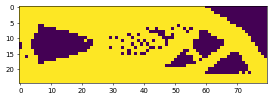

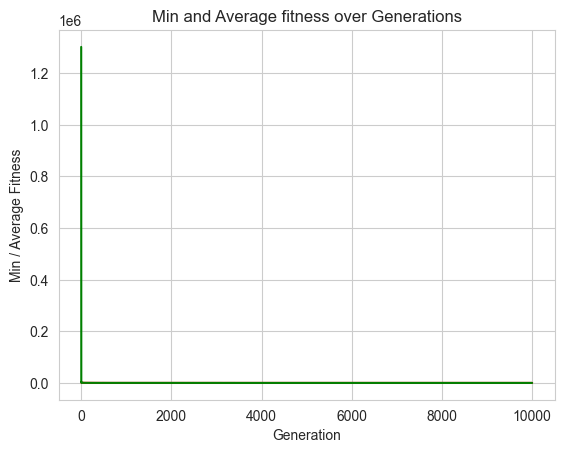

In [30]:
main()